# Project Title: SympToMatch
## Subtitle: Unleashing the power of AI to match patients with the right care


### Goal
The goal of this project is to develop an advanced would classify audio with ailments descriptions into severe and mild, and afterwards matching the ailment with the right medical specialization. The system should be capable of accurately transcribing and understanding spoken queries from callers seeking medical advice or information. The project aims to improve the efficiency and effectiveness of the telenursing service by automating the initial query handling process.


### Approach 
1. __collecting of audio files__ from kaggle (source : https://www.kaggle.com/datasets/paultimothymooney/medical-speech-transcription-and-intent)
2. __transcribing audio into text__
3. __labeling data__ into severe and mild (i.e., 2 classes)
4. __training Model_1__ a supervised ML classification algorithm to discriminte ailments desciptions by severity 
5. __labeling data__ assigning ailments to 12 different medical specializations (i.e., dermatology, gastroenterology, psychology, orthopedy, rheumatology, general, cardiology, ophthalmology, wound care, otorhinolaryngology, emergency - or ER- ,and physiatry)
6. __training Model_2__ a supervised ML classification algorithm to assign ailments in 12 classes
7. __testing Model_1 and Model_2 on unseen data__ to evaluate the performance of the models


In [283]:
# Installing dependencies

## Converting audio to text
# pip install SpeechRecognition
# pip install tqdm

## Extracting features from audio
# pip install pydub

# Classification
# pip install cleantext

# Visualization
# pip install pySankey

In [284]:
# Converting audio to text
import speech_recognition as sr
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.font_manager
from pySankey.sankey import sankey

# Regex
import re

# INLTK resources
import nltk
from nltk.tag import pos_tag
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Word frequency for classification
from nltk.corpus import stopwords
from collections import Counter

# Stemming words
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from functools import reduce

# Converting string to dictionary
import ast

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Suprvised machine learning classification
from cleantext import clean

# Baseline
from sklearn.dummy import DummyClassifier

# Building model 1
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Buildind model 2
from scipy.stats import randint
from io import StringIO
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Loading metrics to evaluate models
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, RocCurveDisplay

# Extracting features from audio files
from pydub import AudioSegment
import librosa
import librosa.display


[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [285]:
# List of functions 

def get_file_name(path):
    """Extract fil name from path. The input is a string."""
    pattern = r"/([^/]+)$"  # Regular expression pattern to match the file name at the end of the path
    match = re.search(pattern, path)
    if match:
        file_name = match.group(1)
        return file_name
    else:
        return None
    
def do_clean(text):
    """The string (text) is converted to lowercase, it is stripped, and the punctualization is removed."""
    return clean(text, lowercase=True, extra_spaces=False, punct=True)


# similar as above
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)


# preprocess the text by removing stopwords and filtering out nouns
def preprocess_text(text):
    stopwords_set = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    nouns = [word for word, tag in pos_tags if tag.startswith('NN') and word.lower() not in stopwords_set]
    return nouns

# Fit the data onto the models
def train(clf, features, targets):
    clf.fit(features, targets)

def predict(clf, features):
    return (clf.predict(features))


# Call it whan testing a new sentence
def find(x):
    if x == 1:
        print ("Severe")
    else:
        print ("Mild")

In [286]:
# Settings for visualizations

# Color palette for all figures (following 1177 color palette)
dark = "#318ccdff" #blue
light= "#e65a67ff" #red

# Font dictionary
font1 = {'family':'Helvetica','color':'black','size':20, 'weight' :"bold"}
font2 = {'family':'Helvetica','color':'black','size':14, 'weight' :"bold"}
font3 = {'family':'Helvetica','color':'black','size':14, 'weight' :"bold"}

# STEP 1
### Collecting audio files from kaggle.

The folder downloaded from Kaggle contains 3 subfolders, named "test", "train" and "validate", with respectively 5895, 381 and 385 wav files. In ecah folder the audio files are unique, however the sentence is repeted, reducing drastically the sample size. Therefore, only the files belonging to the "test" folder are used.

__Tools__: 
- SpeechRecognition library, which supports several speech recognition engines, including Google Speech Recognition
- recognize_google (https://github.com/Uberi/speech_recognition/blob/master/reference/library-reference.rst)
- tqdm (to estimate progress)


### Processing TEST folder

In [287]:
# Set home directory
dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/"
# List of all files in directory
audio_files = os.listdir(dir_path)

# Create a recognizer object
r = sr.Recognizer()

# Create empty lists to store text and filename
text_list = []
filename_list = []

# Process each audio file
for audio_file in tqdm(audio_files, desc="Processing"):
    try:
        audio_path = os.path.join(dir_path, audio_file)

        # Open the audio file
        with sr.AudioFile(audio_path) as source:
            # Read the audio data
            audio_data = r.record(source)

        # Convert speech to text
        text = r.recognize_google(audio_data, show_all=True)

        # Append text and filename to lists
        text_list.append(text)
        filename_list.append(audio_file)
    
    # To handle exeptions, such as empty files
    except sr.RequestError as e:
        print(f"Error processing audio file: {audio_file} - {e}")
        continue
    
    except sr.UnknownValueError:
        print(f"No speech detected in audio file: {audio_file}")
        continue


Processing:   0%|                            | 3/5895 [00:03<1:43:34,  1.05s/it]


KeyboardInterrupt: 

In [ ]:
# Create DataFrame
data = {"Text": text_list, "Filename": filename_list}
df_test = pd.DataFrame(data)
df_test.to_csv("df_test_data.csv", index=False)

In [288]:
# To load the DataFrame without creating from scratch
df_test = pd.read_csv("df_test_part1.csv")

In [289]:
# The `test` contained 5895 files, but the dataframes has 5725 rows, indicating that 170 audios files were compromised.
df_test.shape # 5725, 2  ---> excluded 170 audios files 

(5725, 2)

In [290]:
# Example of  transcripts from the audio file '1249120_30766630_68687326.wav'
df_test.Text[0]

"{'alternative': [{'transcript': 'I had a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'I hod a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'igh had a pain in my knee when I was swimming', 'confidence': 0.97433341}, {'transcript': 'I had a pain in my knee wwhen I was swimming', 'confidence': 0.97433341}, {'transcript': 'I had a pain in my knee when igh was swimming', 'confidence': 0.97433341}], 'final': True}"

# Step 2
### Transcribing audio into text

In [291]:
# Clean Text column (keep 'transcript' and  'confidence' value) 

text_clean_lst = []
confidence_level_lst=[]

for i in range(len(df_test)):

    text = df_test.Text[i]
    if len(text) == 2:
        text_clean_lst.append(None)
        confidence_level_lst.append(None)
    else:
        try: 
            input_dict = ast.literal_eval(text)
            text_clean = input_dict['alternative'][0]['transcript']
            text_clean_lst.append(text_clean)


            confidence_level = input_dict['alternative'][0]['confidence']
            confidence_level_lst.append(confidence_level)

        except (ValueError, KeyError):
            continue

In [292]:
# Merge the text_clean_lst and confidence_level_lst listas as new column of the DataFrame
df_test['text_clean'] = text_clean_lst
df_test['confidence'] = confidence_level_lst

In [293]:
# Drop the 'Text' columns
df_test.drop(columns=['Text'], inplace = True)

# Step 3
### Labeling data for Model 1
Make a phrase-severity dictionary

In [294]:
# Read a file with manually annotated sentences as 1 (severe) or 0 (mild)
ph_severity = pd.read_csv("phrase_severity.csv")
ph_severity.drop_duplicates(subset=['phrase'], keep='first', inplace = True)

In [295]:
ph_severity.head()

,severity,same_phrase,phrase
0,0,A,A terrible fall in hair
9,0,A,After a breakup I feel something strange in me.
21,0,A,After an hard working day I have foot ache
29,1,B,After eating I have burning sensation inside ...
41,0,A,"after playing football, i have muscle pain wit..."


In [296]:
# Merge the file 
overview = pd.read_csv("overview-of-recordings.csv")

In [297]:
ph_severity = overview.merge(ph_severity,how='outer', left_on='phrase', right_on='phrase')

# count Na
# 8 Na --> drop
ph_severity.isna().sum
ph_severity.dropna(inplace = True)

ph_severity.drop(columns=['audio_clipping', 'audio_clipping:confidence',
       'background_noise_audible', 'background_noise_audible:confidence',
       'overall_quality_of_the_audio', 'quiet_speaker',
       'quiet_speaker:confidence', 'speaker_id', 'file_download', 'writer_id', 'same_phrase' ], inplace = True)

In [298]:
ph_severity.columns = ['file_name', 'phrase_orig', 'prompt', 'severity']
ph_severity.columns

Index(['file_name', 'phrase_orig', 'prompt', 'severity'], dtype='object')

In [299]:
## Merge ph_severity with df_test by 'file_name'
df_test = df_test.merge(ph_severity, how='inner', left_on='Filename', right_on='file_name')

In [300]:
df_test.drop(columns=['Filename'], inplace = True)

In [301]:
# check for Nas (n=184)
df_test.isna().sum()
df_test.dropna(inplace = True)

In [302]:
# convert 'text_clean' and 'phrase_orig' to lower case and strip the text
df_test['text_clean'] = df_test['text_clean'].str.lower().str.strip()
df_test['phrase_orig'] = df_test['phrase_orig'].str.lower().str.strip()

In [303]:
# Keep only the row with the highest value in 'confidence' for each unique value in 'phrase_orig'
df_max = df_test.groupby('phrase_orig')['confidence'].idxmax()
df_test = df_test.loc[df_max]

In [304]:
df_test.head() # (695, 7)
df_test.reset_index(inplace = True, drop = True)

In [305]:
df_test.drop(columns=['phrase_orig'], inplace = True)

In [306]:
df_test.tail()

,text_clean,confidence,file_name,prompt,severity
690,when my grandfather died i felt a hard emotion...,0.987629,1249120_38042052_51397205.wav,Emotional pain,0.0
691,whenever i stand up i feel dizzy,0.987629,1249120_40725179_76574514.wav,Feeling dizzy,1.0
692,why is my shoulder aching when i try to pick u...,0.987629,1249120_22423108_32755063.wav,Shoulder pain,1.0
693,yesterday i had a shoulder pain,0.988415,1249120_41203338_74291763.wav,Shoulder pain,0.0
694,you won't believe me but this infected wound o...,0.916063,1249120_30766630_42880428.wav,Infected wound,1.0


### Exploratory analysis

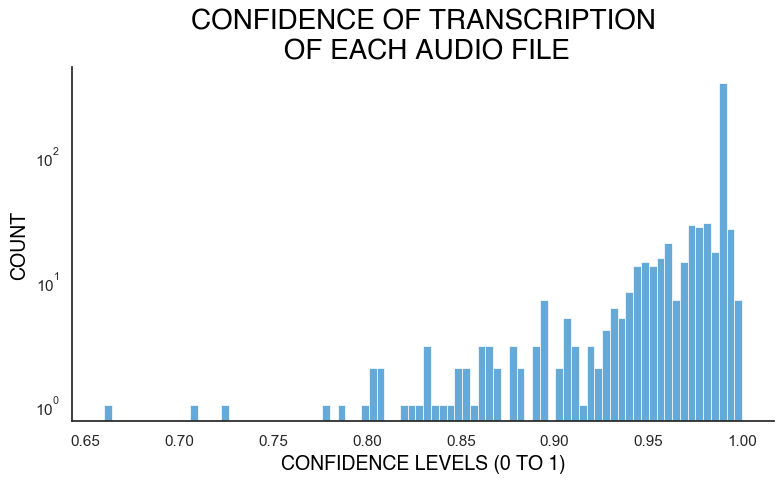

In [307]:
# Set figure size and style
plt.figure(figsize=(8, 5))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(data=df_test, x='confidence', color="#318ccdff")

# Set plot title and labels
plt.title("CONFIDENCE OF TRANSCRIPTION\n OF EACH AUDIO FILE", fontdict=font1)
plt.xlabel("CONFIDENCE LEVELS (0 TO 1)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font3)

# Remove top and right spines
sns.despine()

# Set y-axis to logarithmic scale
plt.yscale("log")

# Adjust plot layout for better readability
plt.tight_layout()

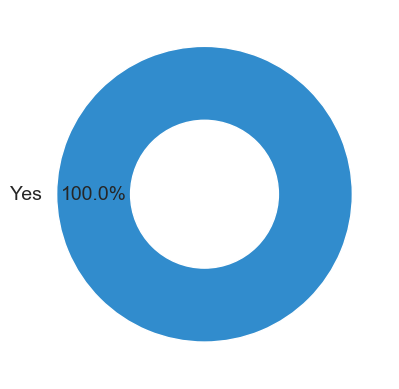

In [308]:
# Donut plot: how many audios are excluded because of bad quality?

df_test['keep'] = np.where(df_test['confidence'] <= 0.5, 'No', 'Yes')

label = list(pd.Series(df_test['keep']).value_counts().index)
count = list(pd.Series(df_test['keep']).value_counts().values)

colors = [dark, light]
#explode = (0.05, 0.05)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.75, textprops={'fontsize': 14})
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [309]:
### Features about the audio

# Load files
dir_path = "/Users/admin/Downloads/archive (3)/medical speech transcription and intent/Medical Speech, Transcription, and Intent/recordings/test/" 
audio_files = os.listdir(dir_path)

audio_duration_lst = []
audio_intesnsity_lst = []

for n in range(len(audio_files)):
    audio = dir_path+audio_files[n]
    audio_segment = AudioSegment.from_file(audio)
    audio_duration_lst.append(len(audio_segment))
    audio_intesnsity_lst.append(audio_segment.dBFS)


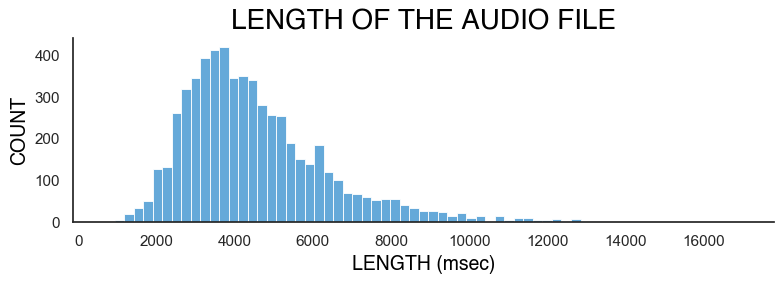

In [310]:
# Set figure style
sns.set(style="white")

# Set figure size and style
plt.figure(figsize=(8, 3))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(audio_duration_lst,  color="#318ccdff")

# Set plot title and labels
plt.title("LENGTH OF THE AUDIO FILE", fontdict=font1)
plt.xlabel("LENGTH (msec)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font3)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


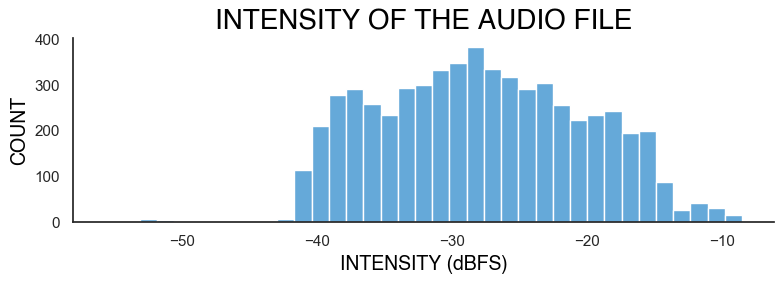

In [311]:
# Set figure style
sns.set(style="white")

# Set figure size and style
plt.figure(figsize=(8, 3))
sns.set(style="white")

# Plot histogram with KDE
sns.histplot(audio_intesnsity_lst, color="#318ccdff")

# Set plot title and labels
plt.title("INTENSITY OF THE AUDIO FILE", fontdict=font1)
plt.xlabel("INTENSITY (dBFS)", fontdict=font2)
plt.ylabel("COUNT", fontdict=font3)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


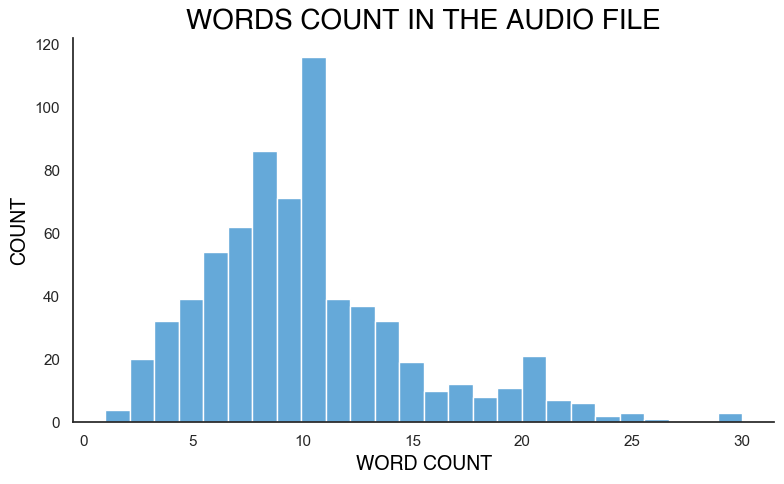

In [312]:
### Feautures about the text

# Set figure size and style
plt.figure(figsize=(8, 5))
sns.set(style="white")

# words count
df_test['word_count'] = df_test['text_clean'].apply(lambda x: len(str(x).split()))
sns.histplot(df_test, x='word_count', color = dark)

# Set plot title and labels
plt.title("WORDS COUNT IN THE AUDIO FILE", fontdict=font1)
plt.xlabel("WORD COUNT", fontdict=font2)
plt.ylabel("COUNT", fontdict=font3)

# Adjust plot layout for better readability
plt.tight_layout()

# Remove top and right spines
sns.despine()


# Step 4
### Model_1: supervised machine learning to classify severe vs mild ailments

In [313]:
# Drop if word_count < 2
df_test = df_test[df_test['word_count']>3]

In [314]:
## Clean dataset
df_test['text_clean_extra_clean'] = df_test['text_clean'].apply(do_clean)

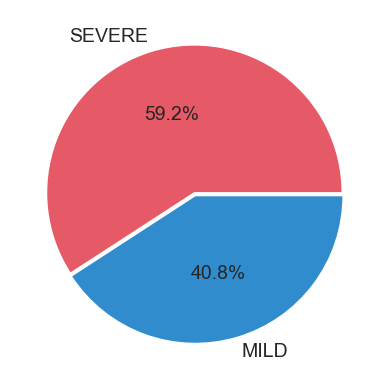

In [315]:
sev_class = pd.Series(df_test.severity).value_counts()
sev_class.index  # [1.0, 0.0]
sev_class.values # [397, 274]

label = ['SEVERE', 'MILD']
count = sev_class.values

colors = [light, dark]
explode = (0.01, 0.01)
plt.pie(count, colors=colors, labels=label,
        autopct='%1.1f%%', pctdistance=0.55, textprops={'fontsize': 14}, explode=explode)
plt.show()

In [316]:
# Generate more labeled phrases using ChatGTP
df_chatGTP = pd.read_csv("chatGTP.csv")

# convert text and promp to lowercase
df_chatGTP['prompt'] = df_chatGTP['prompt'].str.lower()
df_chatGTP['text'] = df_chatGTP['text'].str.lower()

df_chatGTP.columns = ['text_clean', 'severity','prompt']

In [317]:
df_test1 = df_test[['text_clean', 'severity','prompt']].copy()
# Concatenate df_test and df_chatGPT
df_test1 = pd.concat([df_test1, df_chatGTP], ignore_index= True)

In [318]:
df_test1.isna().sum()

text_clean    0
severity      0
prompt        0
dtype: int64

In [319]:
# Create a new dataframe with two columns
df_test1 = df_test1[['severity', 'text_clean']].copy()

In [320]:
# Remove stopwords and punctuation
df_test1['text_clean'] = df_test1['text_clean'].apply(text_process)
df_test1.head()

,severity,text_clean
0,0.0,terrible fall hair
1,0.0,breakup feel something strange
2,1.0,eating burning sensation inside
3,0.0,playing football muscle pain legs
4,0.0,playing tennis powerful sensation close neck


In [321]:
# Stemming words 
ps = PorterStemmer()
stemmed_sentence_lst = []

for sentence in df_test1['text_clean']:
    words = word_tokenize(sentence)
    # using reduce to apply stemmer to each word and join them back into a string
    stemmed_sentence = reduce(lambda x, y: x + " " + ps.stem(y), words, "")
    
    stemmed_sentence_lst.append(stemmed_sentence)

In [322]:
df_test1['stemmed_text_clean'] = stemmed_sentence_lst
df_test1.drop(columns='text_clean', inplace = True)

### Set Baseline for MODEL 1

In [323]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_true = y_test.copy()
y_pred = dummy.predict(X_test)
baseline = accuracy_score(y_true, y_pred)
print(f"The baseline to beat is: {baseline}")

The baseline to beat is: 0.2090032154340836


In [324]:
# Create a new column 'category_id' with encoded categories 
df_test1 = df_test1[['severity', 'stemmed_text_clean']].copy()

df_test1['category_id'] = df_test1['severity'].factorize()[0]
category_id_df = df_test1[['severity', 'category_id']].drop_duplicates()

In [325]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'severity']].values)

# New dataframe
df_test1.head()

,severity,stemmed_text_clean,category_id
0,0.0,terribl fall hair,0
1,0.0,breakup feel someth strang,0
2,1.0,eat burn sensat insid,1
3,0.0,play footbal muscl pain leg,0
4,0.0,play tenni power sensat close neck,0


In [326]:
# The text needs to be transformed to vectors so as the algorithms will be able make predictions.


#  Convert the text data into vectors (TfidfVectorizer)

#  Feature engineering: TF-IDF Vectors as features

## The importance increases proportionally to the number of times a word appears in the review but is 
## offset by the frequency of the word in the entire review corpus.

## TF or Term Frequency measures how frequently a term appears in a document
## IDF or Inverse Document Frequency measures the importance of each term


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# Transform each complain into a vector
features = tfidf.fit_transform(df_test1.stemmed_text_clean).toarray()

labels = df_test1.category_id

print("Each of the %d specializations is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1243 specializations is represented by 359 features (TF-IDF score of unigrams and bigrams)


In [327]:
# Splitting the data into train and test sets
X = df_test1['stemmed_text_clean'] # Collection of documents
y = df_test1['severity'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [328]:
# Models for accuracy
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=49),
    DecisionTreeClassifier(min_samples_split=7, random_state=111)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='recall', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'recall'])

In [329]:
cv_df.groupby('model_name').recall.mean()

model_name
DecisionTreeClassifier    0.715412
KNeighborsClassifier      0.803958
LinearSVC                 0.784997
LogisticRegression        0.839856
MultinomialNB             0.848679
RandomForestClassifier    0.980697
Name: recall, dtype: float64

In [330]:
mean_recall = cv_df.groupby('model_name').recall.mean()
std_recall = cv_df.groupby('model_name').recall.std()

acc = pd.concat([mean_recall, std_recall], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean recall', 'Standard deviation']
acc

,Mean recall,Standard deviation
model_name,,
DecisionTreeClassifier,0.715412,0.221270
KNeighborsClassifier,0.803958,0.060674
LinearSVC,0.784997,0.152204
LogisticRegression,0.839856,0.109265
MultinomialNB,0.848679,0.073900
RandomForestClassifier,0.980697,0.023771


In [331]:
cv_df['col']=np.where(cv_df['model_name']=='RandomForestClassifier', 'red', 'blue')
cv_df['model_name']=cv_df['model_name'].map({'RandomForestClassifier': 'rForest',
                                            'LinearSVC':'linSVC',
                                            'MultinomialNB': 'MulNB',
                                            'LogisticRegression':'LogRex',
                                            'KNeighborsClassifier':'KNC',
                                            'DecisionTreeClassifier':'DecTree'})

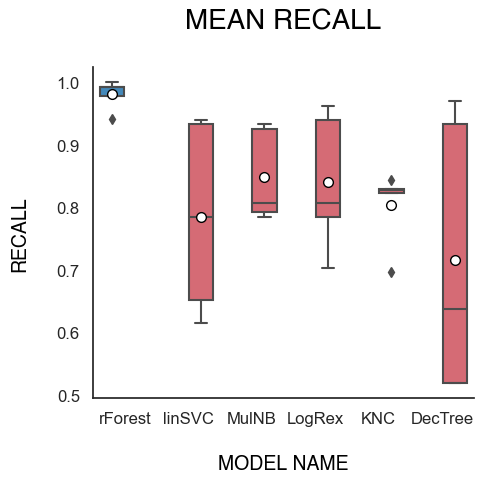

In [332]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='model_name', y='recall', 
            data=cv_df, 
            palette=[dark, light], 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"7"},
           hue = 'col')
plt.title("MEAN RECALL\n",  fontdict= font1)
plt.xlabel("\nMODEL NAME",  fontdict= font2)
plt.ylabel("RECALL\n",  fontdict= font3)
plt.legend([], [], frameon=False, )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


# plt.savefig("boxplot_Model1.png", transparent = True)
# plt.show()

In [333]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_test1.index, test_size=0.25, 
                                                               random_state=1)

In [334]:
# Train
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f"Recall score: {recall_score(y_train, y_pred)}")

Recall score: 0.9294117647058824


In [335]:
print(f"Precision score: {precision_score(y_train, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_train, y_pred)}")
print(f"Recall score: {recall_score(y_train, y_pred)}")

Precision score: 0.8464285714285714
Accuracy score: 0.869098712446352
Recall score: 0.9294117647058824


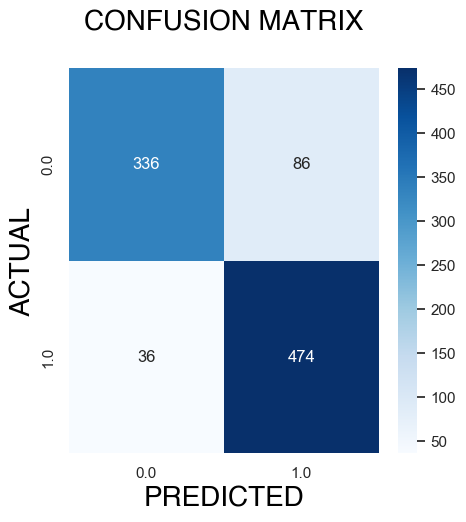

In [336]:
# Confusion matrix train
conf_mat = confusion_matrix(y_train, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.severity.values, 
            yticklabels=category_id_df.severity.values)
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)
plt.savefig("cm_model1_mnb.png", transparent = True)

In [337]:
# Test
model = MultinomialNB()
model.fit(X_test, y_test)
y_pred = model.predict(X_test)
print(f"Recall score: {recall_score(y_test, y_pred)}")

Recall score: 0.9079754601226994


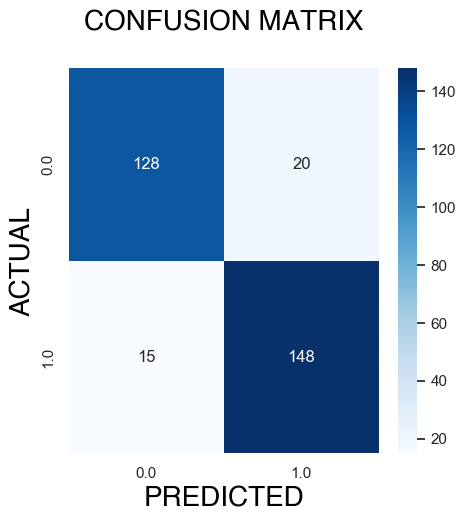

In [338]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.severity.values, 
            yticklabels=category_id_df.severity.values)
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)
plt.savefig("cm_model1_mnb.png", transparent = True)

In [339]:
# Misclassification
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df_test1.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['severity', 
                                                                'stemmed_text_clean']])
            print('')

'1.0' predicted as '0.0' : 15 examples.


,severity,stemmed_text_clean
947,1.0,im feel extrem stress overwhelm
864,1.0,injur knee play sport unstabl
49,1.0,hardli move neck
639,1.0,play sport burn sensat spine
236,1.0,dull ach stomach get wors eat
535,1.0,shoulder muscl hurt tri reach
452,1.0,child cough night cant sleep
8,1.0,annoy start suddenli often injuri exercis
19,1.0,even though adult face keep break pimpl
270,1.0,rash itch bad



'0.0' predicted as '1.0' : 20 examples.


,severity,stemmed_text_clean
616,0.0,help scar heal faster
572,0.0,stand less 5 minut bag start wag
348,0.0,notic lot hair come usual brush hair
383,0.0,travel ship feel dizzi
665,0.0,high start feel dizzi
375,0.0,walk alon 43 km feel pain foot like take
529,0.0,right shoulder click move arm
602,0.0,daddi sharp pain scalp
414,0.0,hurt bend arm
258,0.0,pain joint


In [340]:
print(f"Precision score: {precision_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Recall score: {recall_score(y_test, y_pred)}")

Precision score: 0.8809523809523809
Accuracy score: 0.887459807073955
Recall score: 0.9079754601226994


# Step 5
### Model_2: supervised machine learning to classify 12 medical specialties

In [341]:
df_test2 = df_test[['text_clean', 'severity','prompt']].copy()

In [342]:
# replace exsisting prompts with doctor domains
df_test2['prompt'] = df_test2['prompt'].map({'Infected wound':'wound care', 
                                                   'Back pain':'physiatry', 
                                                   'Blurry vision':'ophthalmology', 
                                                   'Ear ache':'otorhinolaryngology',
                                                   'Body feels weak':'general', 
                                                   'Stomach ache':'gastroenterology', 
                                                   'Foot ache':'orthopedy', 
                                                   'Hard to breath':'ER',
                                                   'Emotional pain':'psychology', 
                                                   'Shoulder pain':'orthopedy', 
                                                   'Feeling dizzy':'general', 
                                                   'Acne':'dermatology',
                                                   'Feeling cold':'general', 
                                                   'Head ache':'general', 
                                                   'Muscle pain':'orthopedy', 
                                                   'Neck pain':'orthopedy',
                                                   'Heart hurts':'cardiology', 
                                                   'Injury from sports':'orthopedy', 
                                                   'Internal pain':'general',
                                                   'Hair falling out':'dermatology', 
                                                   'Cough':'general', 
                                                   'Joint pain':'rheumatology', 
                                                   'Knee pain':'orthopedy',
                                                   'Open wound':'wound care', 
                                                   'Skin issue':'dermatology'})

In [343]:
df_test2['prompt'] = df_test2['prompt'].str.lower()

In [344]:
df_test2.isna().sum()

text_clean    0
severity      0
prompt        0
dtype: int64

In [345]:
# Concatenate df_test and df_chatGPT
df_test2 = pd.concat([df_test2, df_chatGTP], ignore_index= True)

In [346]:
df_test2.prompt[180] = 'orthopedy'

/var/folders/gk/mp0xvl413dq_cb2pj579h7h00000gn/T/ipykernel_60365/2798647016.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [347]:
df_test2.head()

,text_clean,severity,prompt
0,a terrible fall in hair,0.0,dermatology
1,after a breakup i feel something strange in me,0.0,psychology
2,after eating i have burning sensation inside o...,1.0,gastroenterology
3,after playing football i have muscle pain with...,0.0,orthopedy
4,after playing tennis i had a powerful sensatio...,0.0,orthopedy


In [348]:
# Create a sample DataFrame with ailment data
data = df_test2.copy()

data = data.groupby(['severity', 'prompt'])['prompt'].count().unstack().T
data.reset_index(inplace = True)
data.head()


df = {
    'prompt': list(data['prompt']),
    '0.0': list(data[0.0]),
    '1.0': list(data[1.0])
}

df = pd.DataFrame(data)

df = df.melt(id_vars='prompt', var_name='severity', value_name='n')
df['severity'] = df['severity'].astype(float)

df['severity']=df['severity'].map({0.:'mild', 1.:'severe'})
df.head()

,prompt,severity,n
0,cardiology,mild,24
1,dermatology,mild,79
2,er,mild,4
3,gastroenterology,mild,49
4,general,mild,100


In [349]:
fpath=matplotlib.font_manager.findSystemFonts()
fpath

rcParams["font.family"]= "Helvetica"
rcParams["font.family"]

['Helvetica']

In [350]:
plt.rcParams["font.family"]

['Helvetica']

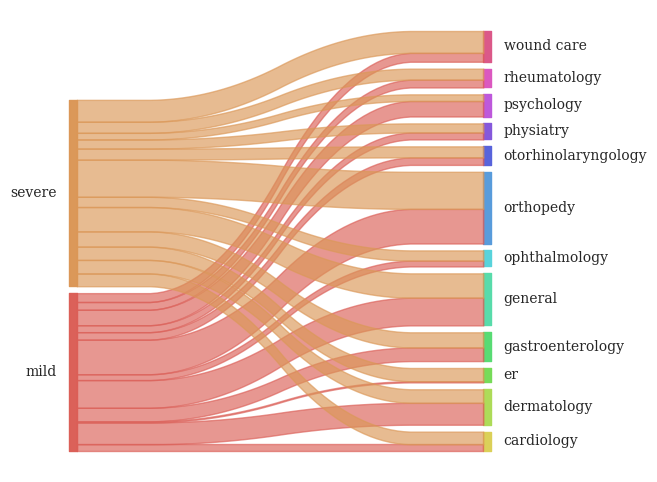

In [351]:
# Import the sankey function from the sankey module within pySankey

colors = {
    'dermatology': '#ffcc00',
    'psychology': '#00cc66',
    'gastroenterology': '#ff6666',
    'orthopedy': '#0099ff',
    'rheumatology': '#9933ff',
    'general': '#ff99cc',
    'cardiology': '#66ccff',
    'ophthalmology': '#ff6699',
    'wound Care': '#ccccff',
    'otorhinolaryngology': '#00ffcc',
    'er': '#ff9933',
    'physiatry': '#99ff33',
    'mild':'#318ccdff', 'severe':'#e65a67ff'
}

sankey(
    left=df["severity"], right=df["prompt"], 
    leftWeight= df["n"], rightWeight=df["n"], 
    aspect=20, fontsize=10
)

plt.savefig("sankey_plot.png", transparent = True)
plt.show()


In [352]:
# Remove stopwords and punctuation
df_test2['text_clean'] = df_test2['text_clean'].apply(text_process)
df_test2.head()

,text_clean,severity,prompt
0,terrible fall hair,0.0,dermatology
1,breakup feel something strange,0.0,psychology
2,eating burning sensation inside,1.0,gastroenterology
3,playing football muscle pain legs,0.0,orthopedy
4,playing tennis powerful sensation close neck,0.0,orthopedy


In [353]:
df_test2['text_clean'][:5]

0                              terrible fall hair
1                  breakup feel something strange
2                 eating burning sensation inside
3               playing football muscle pain legs
4    playing tennis powerful sensation close neck
Name: text_clean, dtype: object

In [354]:
# Stemming words 
ps = PorterStemmer()
stemmed_sentence_lst = []

for sentence in df_test2['text_clean']:
    words = word_tokenize(sentence)
    # using reduce to apply stemmer to each word and join them back into a string
    stemmed_sentence = reduce(lambda x, y: x + " " + ps.stem(y), words, "")
    
    stemmed_sentence_lst.append(stemmed_sentence)

In [355]:
df_test2['stemmed_text_clean'] = stemmed_sentence_lst

In [356]:
df_test2.head()

,text_clean,severity,prompt,stemmed_text_clean
0,terrible fall hair,0.0,dermatology,terribl fall hair
1,breakup feel something strange,0.0,psychology,breakup feel someth strang
2,eating burning sensation inside,1.0,gastroenterology,eat burn sensat insid
3,playing football muscle pain legs,0.0,orthopedy,play footbal muscl pain leg
4,playing tennis powerful sensation close neck,0.0,orthopedy,play tenni power sensat close neck


In [357]:
df_test2['stemmed_text_clean'][:5]

0                      terribl fall hair
1             breakup feel someth strang
2                  eat burn sensat insid
3            play footbal muscl pain leg
4     play tenni power sensat close neck
Name: stemmed_text_clean, dtype: object

In [358]:
df_test2.head()

,text_clean,severity,prompt,stemmed_text_clean
0,terrible fall hair,0.0,dermatology,terribl fall hair
1,breakup feel something strange,0.0,psychology,breakup feel someth strang
2,eating burning sensation inside,1.0,gastroenterology,eat burn sensat insid
3,playing football muscle pain legs,0.0,orthopedy,play footbal muscl pain leg
4,playing tennis powerful sensation close neck,0.0,orthopedy,play tenni power sensat close neck


{'pain': 307, 'feel': 240, 'sever': 216, 'mild': 123, 'occasion': 104, 'im': 67, 'cant': 64, 'back': 61, 'hurt': 61, 'knee': 57, 'joint': 53, 'skin': 53, 'like': 51, 'breath': 49, 'get': 49, 'shoulder': 45, 'stomach': 45, 'cut': 45, 'chest': 44, 'accident': 41}


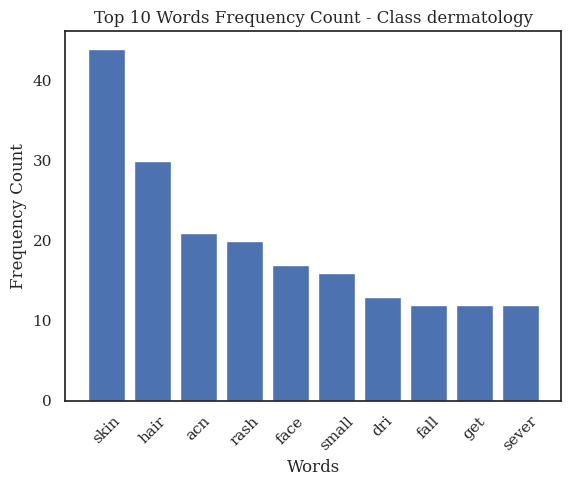

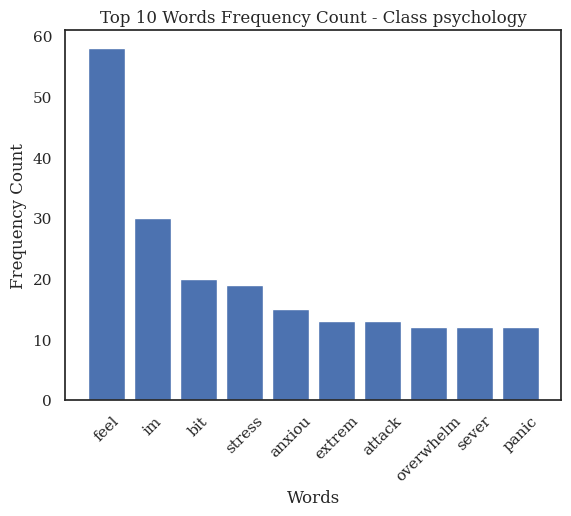

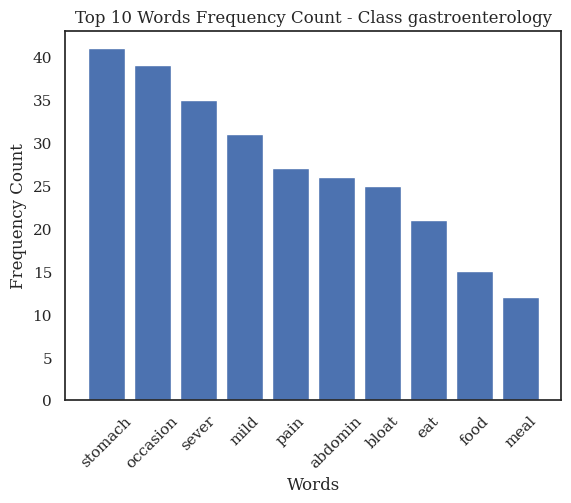

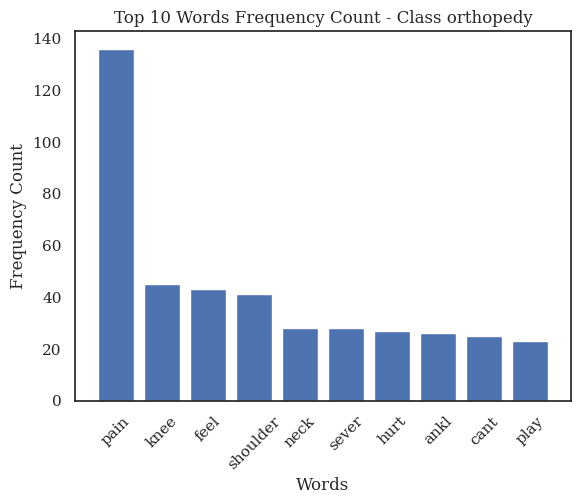

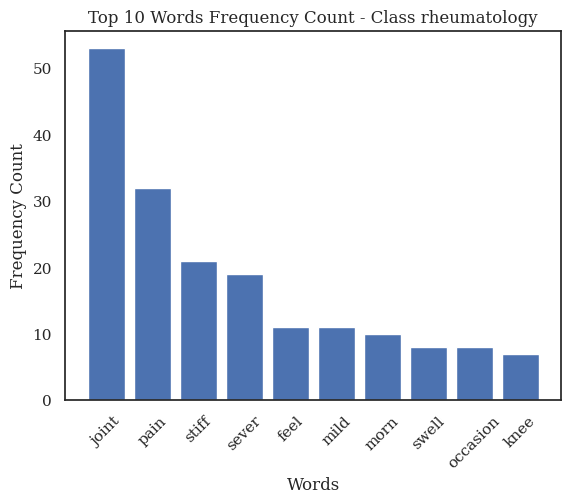

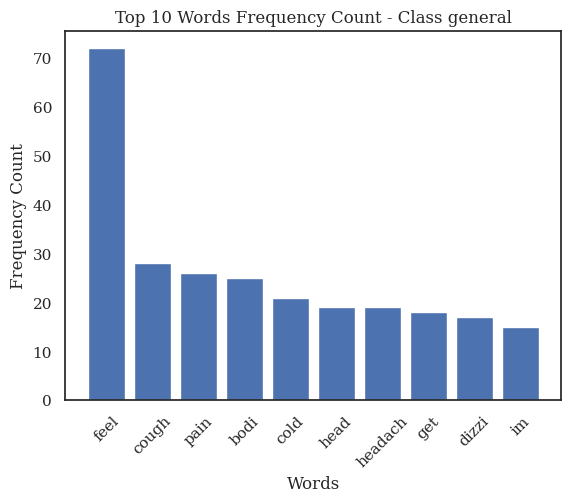

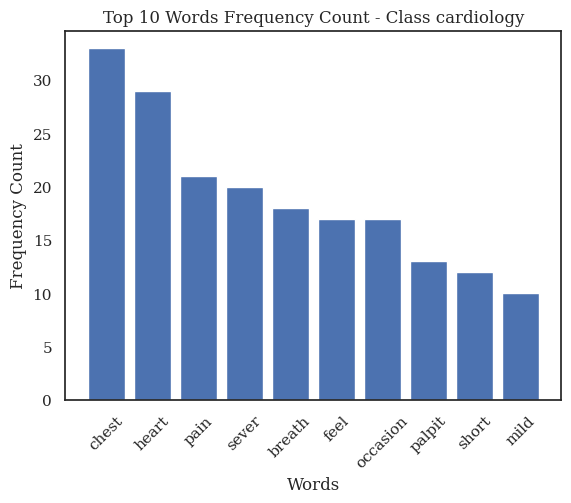

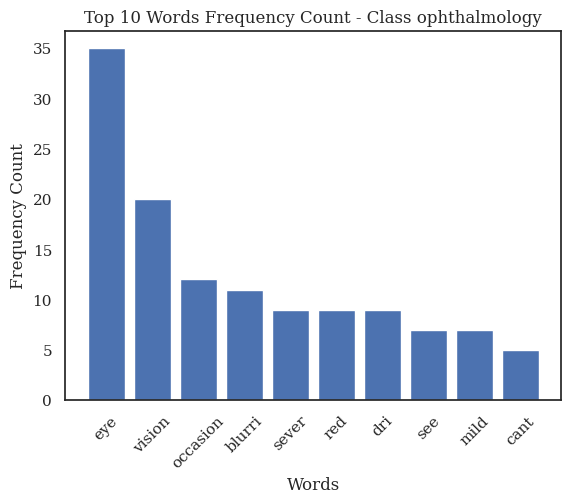

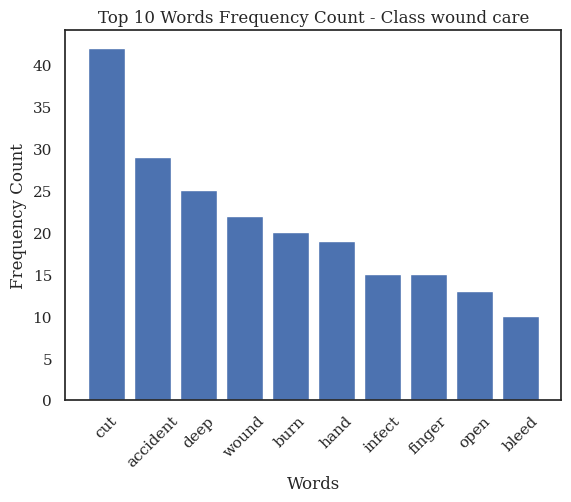

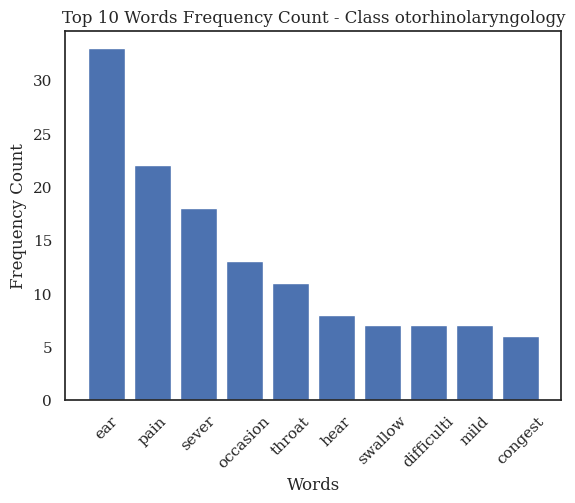

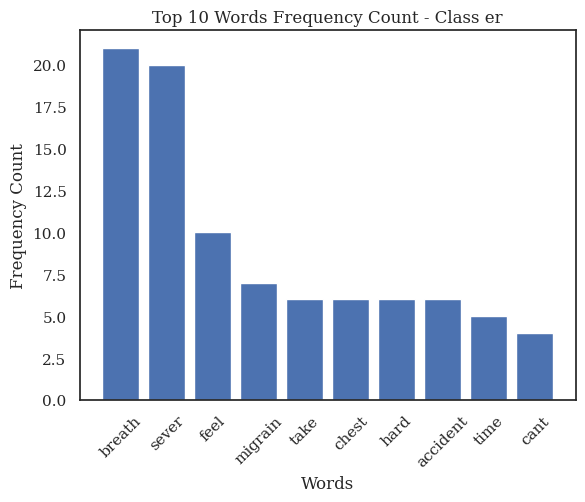

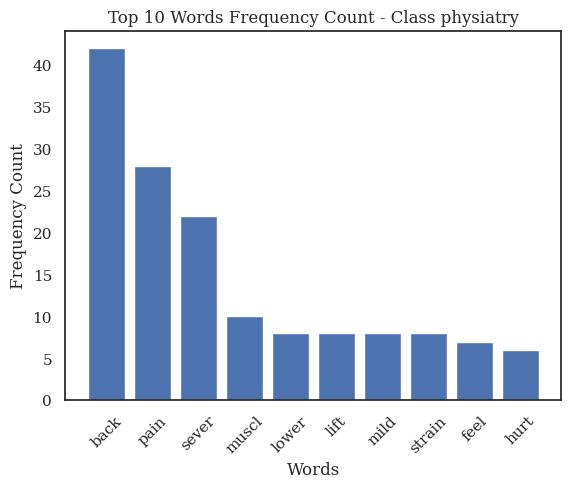

In [359]:
# identify top 10 words in each category

word_counts = Counter(' '.join(df_test2['stemmed_text_clean']).split())
top_20_words = dict(word_counts.most_common(20))
print(top_20_words)

# Calculate frequency count of words per class
class_counts = {}
for cls in df_test2['prompt'].unique():
    filtered_sentences = ' '.join(df_test2[df_test2['prompt'] == cls]['stemmed_text_clean'])
    word_counts = Counter(filtered_sentences.split())
    class_counts[cls] = dict(word_counts.most_common(10))

# Visualize the results for each class
for cls, word_counts in class_counts.items():
    plt.bar(word_counts.keys(), word_counts.values())
    plt.xlabel('Words')
    plt.ylabel('Frequency Count')
    plt.title(f'Top 10 Words Frequency Count - Class {cls}')
    plt.xticks(rotation=45)
    plt.show()


In [361]:
# visalize the most common words per class by a sunburst plot

# Group the data by the "prompt" column and apply preprocessing_text to "text" column:
grouped_data = df_test2.groupby('prompt')['stemmed_text_clean'].apply(lambda x: ' '.join(x)).reset_index()
grouped_data['nouns'] = grouped_data['stemmed_text_clean'].apply(preprocess_text)

# Count frequency of unique nouns for each prompt and select top 10 nouns by frequency
class_noun_counts = grouped_data.explode('nouns').groupby('prompt')['nouns'].value_counts().reset_index(name='count')
top_nouns = class_noun_counts.groupby('prompt').head(10)

# Plot the Sunburst graph
fig = px.sunburst(top_nouns, path=['prompt', 'nouns'], values='count', color='count',
                  color_continuous_scale='reds', title='Top 10 nouns by specialty',
                  maxdepth=-1, branchvalues='total',
                  width=750, height=750)

fig.update_traces(textfont=dict(size=14))
fig.show()

## Multiclass text classification

In [362]:
# Create a new dataframe with two columns
df_test2 = df_test2[['prompt', 'stemmed_text_clean']].copy()

# Create a new column 'category_id' with encoded categories 
df_test2['category_id'] = df_test2['prompt'].factorize()[0]
category_id_df = df_test2[['prompt', 'category_id']].drop_duplicates()

In [363]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'prompt']].values)

# New dataframe
df_test2.head()

,prompt,stemmed_text_clean,category_id
0,dermatology,terribl fall hair,0
1,psychology,breakup feel someth strang,1
2,gastroenterology,eat burn sensat insid,2
3,orthopedy,play footbal muscl pain leg,3
4,orthopedy,play tenni power sensat close neck,3


In [364]:
# The text needs to be transformed to vectors so as the algorithms will be able make predictions.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_test2.stemmed_text_clean).toarray()

labels = df_test2.category_id

print("Each of the %d specializations is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1243 specializations is represented by 359 features (TF-IDF score of unigrams and bigrams)


## Multi-Classification models
The classification models evaluated are:

Random Forest
Linear Support Vector Machine
Multinomial Naive Bayes
Logistic Regression.

In [365]:
# Spliting the data into train and test sets
X = df_test2['stemmed_text_clean'] # Collection of documents
y = df_test2['prompt'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

In [366]:
# Baseline MODEL 2

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

y_true = y_test.copy()
y_pred = dummy.predict(X_test)
baseline = accuracy_score(y_true, y_pred)
print(f"The baseline to beat is: {baseline}")

The baseline to beat is: 0.2090032154340836


### Accuracy

In [367]:
# Models for accuracy
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=49),
    DecisionTreeClassifier(min_samples_split=7, random_state=111)    
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [368]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
DecisionTreeClassifier,0.659833,0.085744
KNeighborsClassifier,0.700826,0.079976
LinearSVC,0.783677,0.061319
LogisticRegression,0.737051,0.091338
MultinomialNB,0.696836,0.101617
RandomForestClassifier,0.471564,0.085587


In [369]:
cv_df['col']=np.where(cv_df['model_name']=='LinearSVC', 'red', 'blue')
cv_df['model_name']=cv_df['model_name'].map({'RandomForestClassifier': 'rForest',
                                            'LinearSVC':'linSVC',
                                            'MultinomialNB': 'MulNB',
                                            'LogisticRegression':'LogRex',
                                            'KNeighborsClassifier':'KNC',
                                            'DecisionTreeClassifier':'DecTree'})


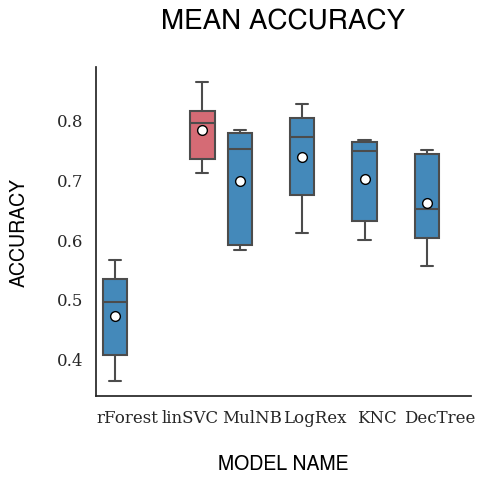

In [370]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            palette=[dark, light], 
            showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"7"},
           hue = 'col')
plt.title("MEAN ACCURACY\n",  fontdict= font1)
plt.xlabel("\nMODEL NAME",  fontdict= font2)
plt.ylabel("ACCURACY\n",  fontdict= font3)
plt.legend([], [], frameon=False, )
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right spines
sns.despine()

# Adjust plot layout for better readability
plt.tight_layout()


plt.savefig("boxplot_Model2.png", transparent = True)

plt.show()


In [371]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_test2.index, test_size=0.25, 
                                                               random_state=1)
model_2 = LinearSVC()
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)
print(f"Recall score: {accuracy_score(y_test, y_pred)}")

Recall score: 0.8231511254019293


In [372]:
# Classification report
print('\t\t\t\tCLASSIFICATION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df_test2['prompt'].unique()))

				CLASSIFICATION METRICS

                     precision    recall  f1-score   support

        dermatology       0.95      0.95      0.95        38
         psychology       1.00      0.81      0.90        16
   gastroenterology       0.89      1.00      0.94        25
          orthopedy       0.73      0.97      0.83        70
       rheumatology       1.00      0.68      0.81        19
            general       0.78      0.64      0.71        45
         cardiology       0.94      0.89      0.91        18
      ophthalmology       0.83      0.77      0.80        13
         wound care       0.86      0.89      0.88        28
otorhinolaryngology       0.73      0.67      0.70        12
                 er       0.73      0.57      0.64        14
          physiatry       0.56      0.38      0.45        13

           accuracy                           0.82       311
          macro avg       0.83      0.77      0.79       311
       weighted avg       0.83      0.82      0.82     

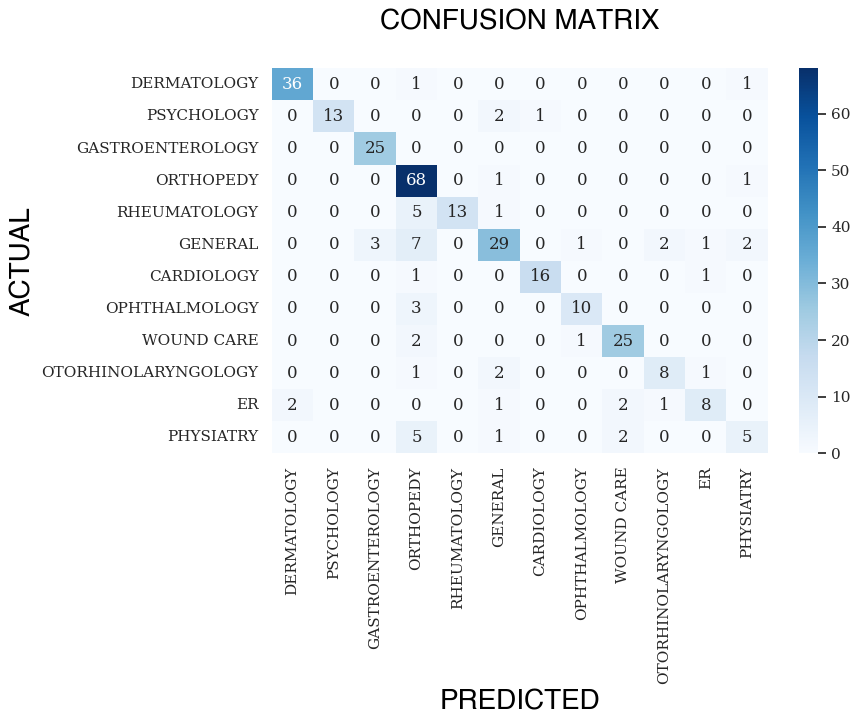

In [373]:
# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=[item.upper() for item in list(category_id_df.prompt.values)], 
            yticklabels=[item.upper() for item in list(category_id_df.prompt.values)])
plt.ylabel('ACTUAL', fontdict=font1)
plt.xlabel('PREDICTED', fontdict=font1)
plt.title("CONFUSION MATRIX\n", fontdict=font1)
plt.savefig("cm_model2.png", transparent = True)

In [374]:
# Misclassification
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
            display(df_test2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['prompt', 
                                                                'stemmed_text_clean']])
            print('')

'er' predicted as 'dermatology' : 2 examples.


,prompt,stemmed_text_clean
1119,er,sever allerg reaction hive swell
730,er,sever allerg reaction swell bodi



'general' predicted as 'gastroenterology' : 3 examples.


,prompt,stemmed_text_clean
131,general,feel dizzi sever diarrhea
236,general,dull ach stomach get wors eat
134,general,laptop hour possibl could reason



'dermatology' predicted as 'orthopedy' : 1 examples.


,prompt,stemmed_text_clean
567,dermatology,someth dark arm



'rheumatology' predicted as 'orthopedy' : 5 examples.


,prompt,stemmed_text_clean
414,rheumatology,hurt bend arm
1233,rheumatology,mild hand stiff morn
101,rheumatology,feel click sensat knee time step
767,rheumatology,sever muscl pain stiff bodi
430,rheumatology,ankl hurt



'general' predicted as 'orthopedy' : 7 examples.


,prompt,stemmed_text_clean
672,general,notic larg pain lump neck
372,general,wake night feel cold
612,general,must someth wrong blood circul wear sock even...
201,general,get chill ach
262,general,pain intern
304,general,havent found get light bother
311,general,pain cant specifi place



'cardiology' predicted as 'orthopedy' : 1 examples.


,prompt,stemmed_text_clean
76,cardiology,left shoulder



'ophthalmology' predicted as 'orthopedy' : 3 examples.


,prompt,stemmed_text_clean
62,ophthalmology,cant see well
268,ophthalmology,famili
573,ophthalmology,sterl silver egg



'wound care' predicted as 'orthopedy' : 2 examples.


,prompt,stemmed_text_clean
521,wound care,muscl lower back
607,wound care,injur person



'otorhinolaryngology' predicted as 'orthopedy' : 1 examples.


,prompt,stemmed_text_clean
198,otorhinolaryngology,get erect cool



'physiatry' predicted as 'orthopedy' : 5 examples.


,prompt,stemmed_text_clean
619,physiatry,bend get shoot pain back
435,physiatry,back hurt cant bend walk
639,physiatry,play sport burn sensat spine
321,physiatry,shoot pain back
220,physiatry,back pain sinc fell floor



'psychology' predicted as 'general' : 2 examples.


,prompt,stemmed_text_clean
148,psychology,feel like cant cope anymor feel overwhelm lik...
404,psychology,tri read book noth cheer



'orthopedy' predicted as 'general' : 1 examples.


,prompt,stemmed_text_clean
446,orthopedy,calv feel like tight throb



'rheumatology' predicted as 'general' : 1 examples.


,prompt,stemmed_text_clean
6,rheumatology,bodi bad case need good treatment



'otorhinolaryngology' predicted as 'general' : 2 examples.


,prompt,stemmed_text_clean
419,otorhinolaryngology,start edit l today pain throb unbear
725,otorhinolaryngology,sever sinu headach facial pressur



'er' predicted as 'general' : 1 examples.


,prompt,stemmed_text_clean
683,er,persist cough blood phlegm



'physiatry' predicted as 'general' : 1 examples.


,prompt,stemmed_text_clean
572,physiatry,stand less 5 minut bag start wag



'psychology' predicted as 'cardiology' : 1 examples.


,prompt,stemmed_text_clean
142,psychology,feel hurt lot pain heart



'general' predicted as 'ophthalmology' : 1 examples.


,prompt,stemmed_text_clean
205,general,get terribl headach everi month get vision af...



'wound care' predicted as 'ophthalmology' : 1 examples.


,prompt,stemmed_text_clean
195,wound care,fell window clean shard glass stuck left eye ...



'er' predicted as 'wound care' : 2 examples.


,prompt,stemmed_text_clean
701,er,sever toothach jaw swollen
1118,er,sever bleed wound wont stop



'physiatry' predicted as 'wound care' : 2 examples.


,prompt,stemmed_text_clean
556,physiatry,upper back sore week
424,physiatry,longitudin burn line across back hard respira...



'general' predicted as 'otorhinolaryngology' : 2 examples.


,prompt,stemmed_text_clean
1215,general,mild sore throat occasion cough
126,general,feel congest chest



'er' predicted as 'otorhinolaryngology' : 1 examples.


,prompt,stemmed_text_clean
528,er,nose congest time there gluey secret throat m...



'general' predicted as 'er' : 1 examples.


,prompt,stemmed_text_clean
325,general,terribl problem im breath night



'cardiology' predicted as 'er' : 1 examples.


,prompt,stemmed_text_clean
880,cardiology,sever chest tight difficulti breath



'otorhinolaryngology' predicted as 'er' : 1 examples.


,prompt,stemmed_text_clean
267,otorhinolaryngology,problem rome itali year made infect



'dermatology' predicted as 'physiatry' : 1 examples.


,prompt,stemmed_text_clean
720,dermatology,sever sunburn blister



'orthopedy' predicted as 'physiatry' : 1 examples.


,prompt,stemmed_text_clean
503,orthopedy,knee catch hurt first stand sit



'general' predicted as 'physiatry' : 2 examples.


,prompt,stemmed_text_clean
735,general,sever menstrual cramp heavi bleed
623,general,drink lot get architect


In [375]:
# Most correlated terms with each category
model_2.fit(features, labels)

N = 4
for prompt, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model_2.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(prompt))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'cardiology':
  * Top unigrams: heart, chest, palpit, left
  * Top bigrams: pain chest, short breath, occasion feel, heart hurt

==> 'dermatology':
  * Top unigrams: hair, acn, skin, rash
  * Top bigrams: sever skin, hair fall, lot hair, wont away

==> 'er':
  * Top unigrams: breath, accident, migrain, time
  * Top bigrams: sever migrain, sever allerg, sometim feel, like someth

==> 'gastroenterology':
  * Top unigrams: stomach, indigest, heartburn, abdomin
  * Top bigrams: stomach ach, abdomin pain, occasion bloat, sever abdomin

==> 'general':
  * Top unigrams: cough, weak, headach, head
  * Top bigrams: feel dizzi, head hurt, pain head, feel cold

==> 'ophthalmology':
  * Top unigrams: eye, vision, glass, blurri
  * Top bigrams: mild eye, dri eye, sever eye, blurri vision

==> 'orthopedy':
  * Top unigrams: wrist, neck, knee, shoulder
  * Top bigrams: muscl pain, knee pain, pain neck, shoulder pain

==> 'otorhinolaryngology':
  * Top unigrams: ear, hear, congest, pressur
  * To

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



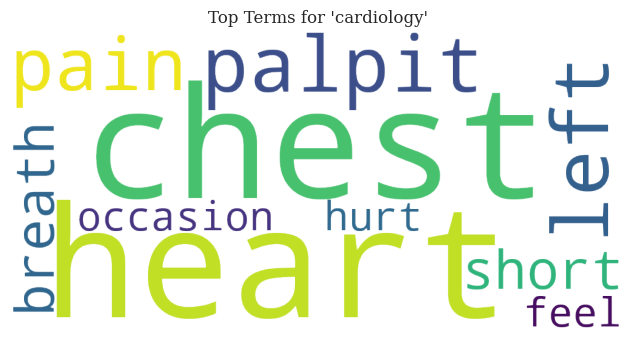

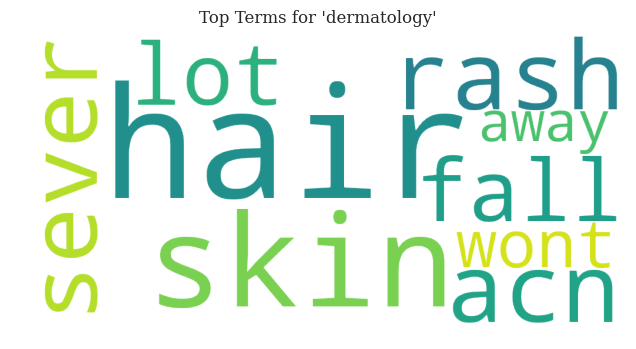

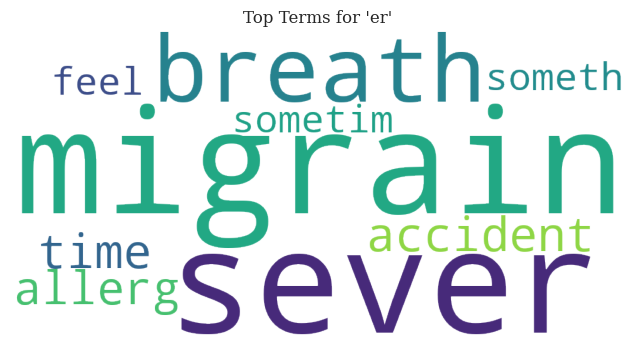

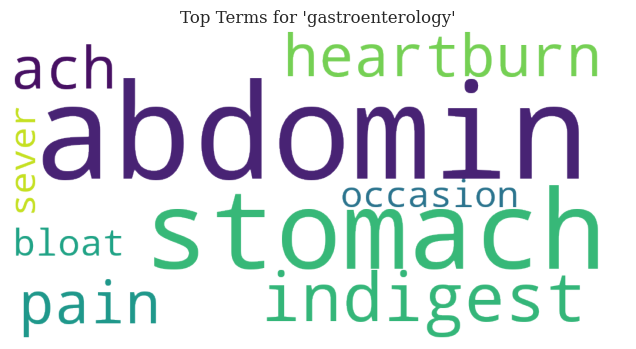

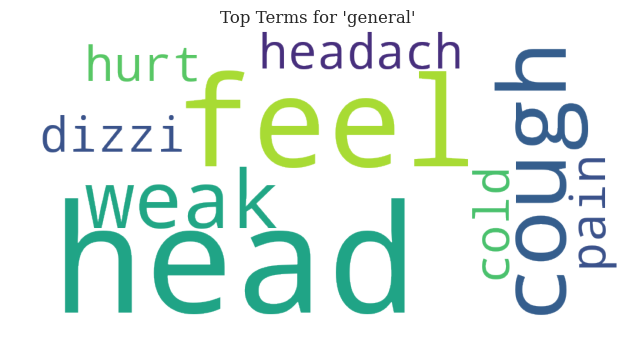

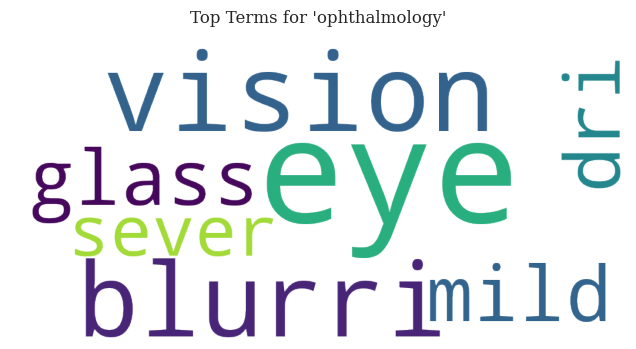

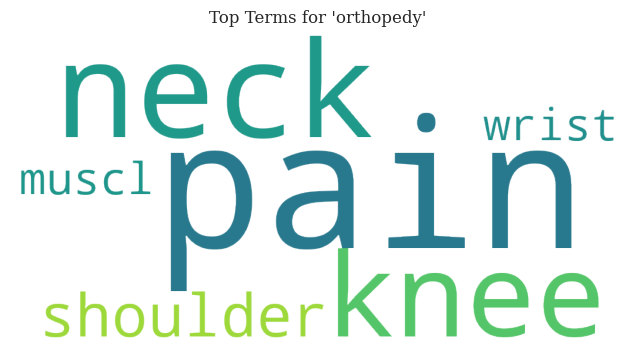

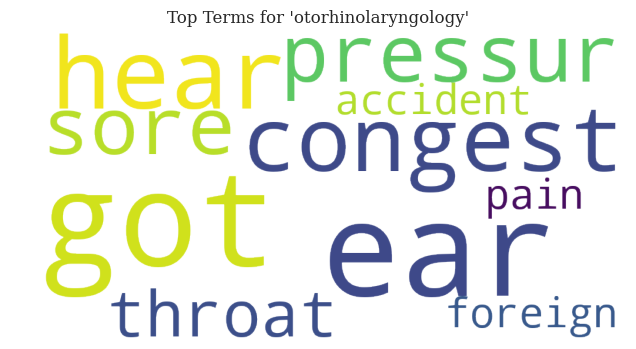

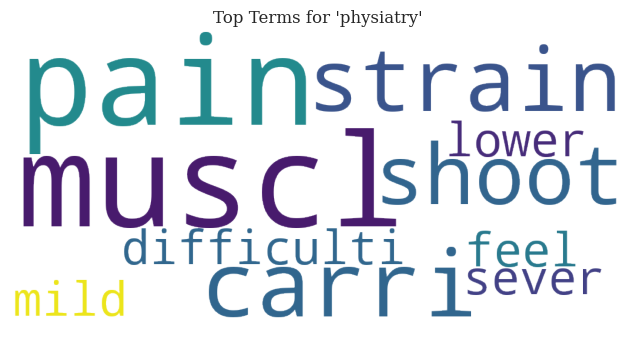

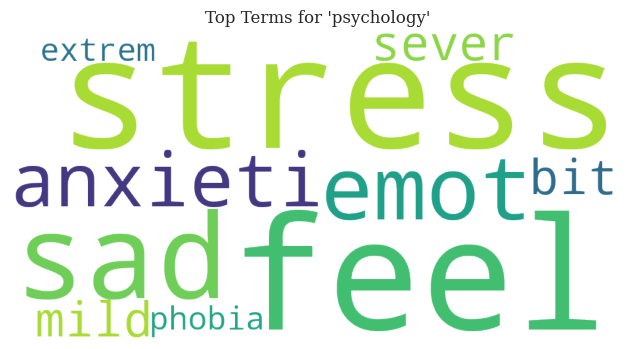

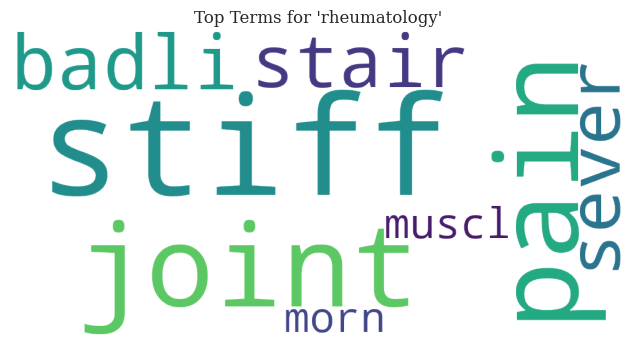

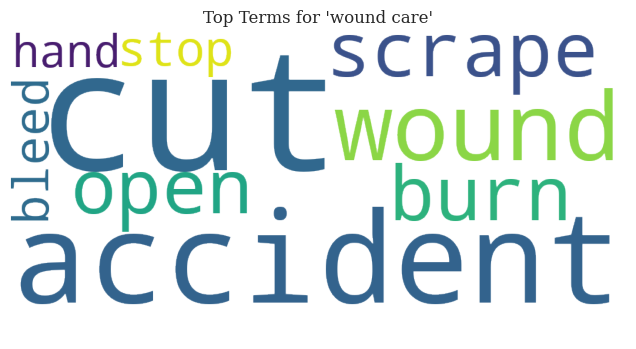

In [376]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create word clouds for each prompt
for prompt, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model_2.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:4]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:4]
    
    # Combine unigrams and bigrams into a single list
    top_terms = unigrams + bigrams
    
    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='rgba(255, 255, 255, 0)', mode='RGBA').generate(' '.join(top_terms))
    
    # Plot the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Top Terms for '{}'".format(prompt))
    plt.axis('off')
    
    # Save the word cloud as PNG with transparent background
    wordcloud.to_file('wordcloud_{}.png'.format(prompt.replace(" ", "_")))
    
    plt.show()


# Step 7
## Testing Model_1 and Model_2 on unseen data

In [388]:
# input
text = "I feel so very alone."
newtext1 = [text]


# Model 1
integers = vectorizer.transform(newtext1)
Model_1 = mnb.predict(integers)

#Model 2
integers = vectorizer.transform(list(newtext1))
Model_2 = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

key = Model_2.predict(fitted_vectorizer.transform([text]))[0]
specialty = list(filter(lambda x: category_to_id[x] == key, category_to_id))[0]

# Print statements
print(f"\tThe sentence is:\n\t {text}")
print("")
if Model_1[0] == 1: 
    print("Your condition is classified as 'severe'.")
    print(f"We strongly recommend to consult a doctor specialized in {specialty}.")
else: 
    print("Your condition is classified as 'mild'.")
    print(f"You might consider booking an appointment in the future with a doctor specialized in {specialty}.")

	The sentence is:
	 I feel so very alone.

Your condition is classified as 'mild'.
You might consider booking an appointment in the future with a doctor specialized in general.
